## Import the required modules.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install --upgrade keras
!pip install keras.utils

import seaborn as sns; sns.set()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 517.3 kB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 1.7 MB/s eta 0:00:00a 0:00:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 1.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.5/87.5 kB 1.4 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-macos 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.
  Preparing metadata (setup.py) ... done
  Created wheel for keras.utils: filename=keras_utils-1.0.13-py3-none-any.whl size=2634 sh

In [2]:
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Bidirectional
from keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
import sys
sys.path.append("/path/to/keras/utils")
from tensorflow.keras.utils import to_categorical

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix

## number_of_samples determine how many samples from the attack and normal dataset should be read and used.

In [3]:
number_of_samples = 50000

## Read data from attack and normal datasets.

In [4]:
data_attack = pd.read_csv('dataset_attack.csv', nrows = number_of_samples)

In [5]:
data_normal = pd.read_csv('dataset_normal.csv', nrows = number_of_samples)

In [6]:
data_normal.columns=[ 'frame.len', 'frame.protocols', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta','class']
data_attack.columns=[ 'frame.len', 'frame.protocols', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'ip.src', 'ip.dst', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta','class']

## Drop unwanted columns

In [7]:
data_normal=data_normal.drop(['ip.src', 'ip.dst','frame.protocols'],axis=1)
data_attack=data_attack.drop(['ip.src', 'ip.dst','frame.protocols'],axis=1)

In [8]:
features=[ 'frame.len', 'ip.hdr_len',
       'ip.len', 'ip.flags.rb', 'ip.flags.df', 'p.flags.mf', 'ip.frag_offset',
       'ip.ttl', 'ip.proto', 'tcp.srcport', 'tcp.dstport',
       'tcp.len', 'tcp.ack', 'tcp.flags.res', 'tcp.flags.ns', 'tcp.flags.cwr',
       'tcp.flags.ecn', 'tcp.flags.urg', 'tcp.flags.ack', 'tcp.flags.push',
       'tcp.flags.reset', 'tcp.flags.syn', 'tcp.flags.fin', 'tcp.window_size',
       'tcp.time_delta']

In [9]:
X_normal= data_normal[features].values
X_attack= data_attack[features].values
Y_normal= data_normal['class']
Y_attack= data_attack['class']
X=np.concatenate((X_normal,X_attack))
Y=np.concatenate((Y_normal,Y_attack))

## Standardise the data

In [10]:
scalar = StandardScaler(copy=True, with_mean=True, with_std=True)
scalar.fit(X)
X = scalar.transform(X)

## The class field, replace value 'attack' with 0 and 'normal' with 1

In [11]:
for i in range(0,len(Y)):
  if Y[i] =="attack":
    Y[i]=0
  else:
    Y[i]=1
    

After feature transformation, we get a 𝑚×𝑛' matrix, where 𝑚 indicates the number of packets and 𝑛' indicates the number of new features after transformation. In order to learn patterns in both long and short term, we use a sliding window to separate continuous packets and reshape the data into a series of time windows with window size 𝑇. The label 𝑦 in each window illustrates the last packet. After reshaping, we have a three-dimensional matrix with shape (𝑚−𝑇 )×𝑇 ×𝑛'. Figure illustrates the workflow of feature extraction, transformation, and reshaping.
![dataset transformation](feature_extraction.png)
In this way, we change the features from conventional packet-based to window-based, by which we can learn network patterns from both previous (𝑇 −1) packets and current packet.

In [12]:
features = len(X[0])
samples = X.shape[0]
train_len = 25
input_len = samples - train_len
I = np.zeros((samples - train_len, train_len, features))

for i in range(input_len):
    temp = np.zeros((train_len, features))
    for j in range(i, i + train_len - 1):
        temp[j-i] = X[j]
    I[i] = temp

In [13]:
X.shape

(100000, 25)

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(I, Y[25:100000], test_size = 0.2)

## The architecture used is![Model](model_brnn.png)

In [15]:
def create_baseline():
    model = Sequential()
    
    model.add(Bidirectional(LSTM(64, activation='tanh', kernel_regularizer='l2')))
    model.add(Dense(128, activation = 'relu', kernel_regularizer='l2'))
    model.add(Dense(1, activation = 'sigmoid', kernel_regularizer='l2'))
    
    model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [16]:
model = create_baseline()

In [17]:
print(f"Type of X_train: {type(X_train[0][0])}")
print(f"Type of Y_train: {type(Y_train[0])}")

Type of X_train: <class 'numpy.ndarray'>
Type of Y_train: <class 'int'>


In [18]:
if type(X_train[0][0]) == int:
    X_train = X_train.astype(np.float32)

if type(Y_train[0]) == int:
    Y_train = Y_train.astype(np.float32)

In [19]:
history = model.fit(X_train, Y_train, epochs = 40,validation_split=0.2, verbose = 1)

Epoch 1/40
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 31s 14ms/step - accuracy: 0.9176 - loss: 0.5289 - val_accuracy: 0.9483 - val_loss: 0.1915
Epoch 2/40
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 29s 15ms/step - accuracy: 0.9547 - loss: 0.1796 - val_accuracy: 0.9544 - val_loss: 0.1673
Epoch 3/40
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - accuracy: 0.9587 - loss: 0.1572 - val_accuracy: 0.9570 - val_loss: 0.1455
Epoch 4/40
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - accuracy: 0.9587 - loss: 0.1520 - val_accuracy: 0.9513 - val_loss: 0.1654
Epoch 5/40
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - accuracy: 0.9598 - loss: 0.1470 - val_accuracy: 0.9582 - val_loss: 0.1385
Epoch 6/40
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - accuracy: 0.9596 - loss: 0.1448 - val_accuracy: 0.9566 - val_loss: 0.1515
Epoch 7/40
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 28s 14ms/step - accuracy: 0.9619 - loss: 0.1413 - val_accuracy: 0.9556 - val_loss: 0.1644
Epoch 8/40
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 29s 14ms/step - accuracy: 0.9657 -

## Obtained plot of accuracy![plot of accuracy](BRNN_Model_Accuracy.png)

In [32]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('BRNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.savefig('BRNN Model Accuracy.png')
plt.show()

KeyError: 'acc'

Plot of loss
![plot of loss](BRNN_Model_Loss.png)

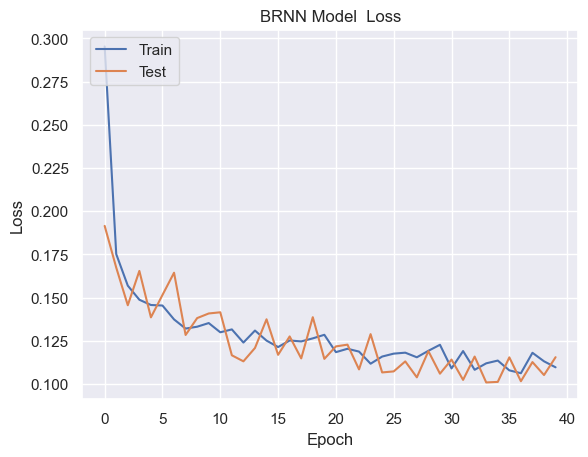

In [24]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('BRNN Model  Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('BRNN Model Loss.png')
plt.show()


In [25]:
predict = model.predict(X_test, verbose=1)

625/625 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step


##  Calculate True positive,True negetive,False positive and False negetive values. Create Heatmap.

In [26]:
tp = 0
tn = 0
fp = 0
fn = 0
predictn = predict.flatten().round()
predictn = predictn.tolist()
Y_testn = Y_test.tolist()
for i in range(len(Y_testn)):
  if predictn[i]==1 and Y_testn[i]==1:
    tp+=1
  elif predictn[i]==0 and Y_testn[i]==0:
    tn+=1
  elif predictn[i]==0 and Y_testn[i]==1:
    fp+=1
  elif predictn[i]==1 and Y_testn[i]==0:
    fn+=1


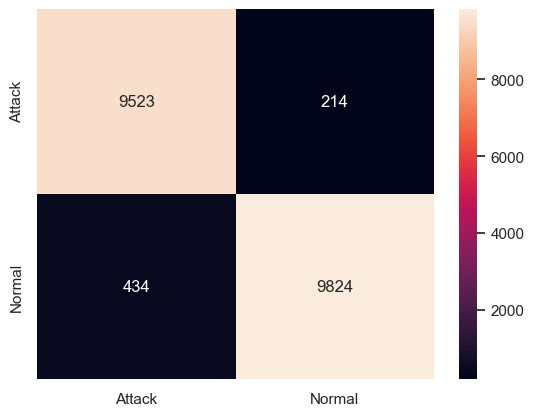

In [27]:
to_heat_map =[[tn,fp],[fn,tp]]
to_heat_map = pd.DataFrame(to_heat_map, index = ["Attack","Normal"],columns = ["Attack","Normal"])
ax = sns.heatmap(to_heat_map,annot=True, fmt="d")

## Save details 

In [28]:
figure = ax.get_figure()    
figure.savefig('confusion_matrix_BRNN.png', dpi=400)

In [29]:
model.save('brnn_model.h5')

In [30]:
import tensorflow as tf

Y_test = Y_test.astype(int)
X_test_tensor = tf.convert_to_tensor(X_test)
Y_test_tensor = tf.convert_to_tensor(Y_test)
scores = model.evaluate(X_test, Y_test, verbose=0)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

compile_metrics: 96.76%
